This notebook trains a single nonlinear Pendulum model to reproduce the results from [Champion et. al](https://www.pnas.org/doi/full/10.1073/pnas.1906995116). The data generation is specified in the  [appendix](https://www.pnas.org/action/downloadSupplement?doi=10.1073%2Fpnas.1906995116&file=pnas.1906995116.sapp.pdf) of [Champion et. al](https://www.pnas.org/doi/full/10.1073/pnas.1906995116), and is restated here. 






The nonlinear pendulum equation is given by

\begin{equation}
\ddot{z} = -sin(z)
\end{equation}

Here $z$ denotes the angle between the vertical and the pendulum

(-0.5, 1.1, -0.9, 0.1)

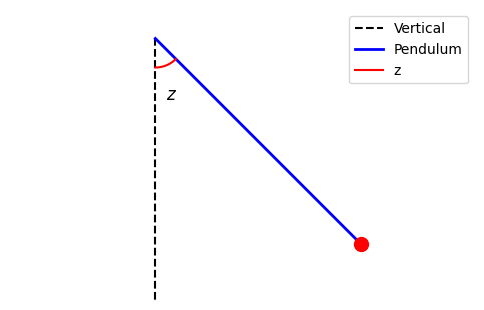

In [10]:
import matplotlib.pyplot as plt
import numpy as np

L = 1.0 
z = np.pi / 4  
# Calculate the pendulum's end point
x = L * np.sin(z)
y = -L * np.cos(z)

fig, ax = plt.subplots(figsize=(6, 6))  

ax.plot([0, 0], [0, -L], 'k--', label='Vertical')
ax.plot([0, x], [0, y], 'b-', linewidth=2, label='Pendulum')

arc = np.linspace(0, z, 100)
ax.plot(0.1 * L * np.sin(arc), -0.1 * L * np.cos(arc), 'r', label='z')

text_x = 0.1 * L * np.sin(z / 2)
text_y = -0.1 * L * np.cos(z / 2) - 0.1  

# Annotate the angle z
ax.text(text_x, text_y, r'$z$', fontsize=12, ha='left', va='center')

ax.plot(x, y, 'ro', markersize=10)


ax.set_aspect('equal')
ax.set_xlim(-0.5, 1.1)  # Adjust limits to reduce white space
ax.set_ylim(-0.9, 0.1)  
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.legend()
ax.axis('off')



As per the appendix "We generate synthetic video of the pendulum in two spatial dimensions by creating high-dimensional snapshots given by"

$$
x(y_1, y_2, t) = exp \left( -20 \left(  (y_1 - cos(z(t)) - \pi/2)\right)^2 + (y_2  - sin(z(t)) - \pi/2)^2 \right) \tag{1}
$$


"at a discretization of $y_1, y_2 \in [−1.5, 1.5]$ . We use 51 grid points in each dimension resulting in snapshots $x(t) \in \mathbb{R}^{2601}$..."

For the training data Kathleen proceeded to simulate Eq. (1) from 100 randomly chosen initial conditions. However, due to our implementation using JAX arrays instead of more sophisticated data loading techniques, we encountered GPU memory issues with such a large dataset. As a result, we opted to use 50 initial conditions instead and 10 for the validation


with  $z(0) \in [-\pi, \pi]$ and $\dot{z(0)} \in [−2.1, 2.1]$. The
initial conditions are selected from a uniform distribution in the specified range but are restricted to conditions for which the
pendulum does not have enough energy to do a full loop. This condition is determined by checking that $|\dot{z}(0)^2/2−cos z(0)| ≤ 0.99$."

##### Note: An animation of this data for one inital condition can be seen in the pendulum_animation.gif

##### Check if jax is using GPU

In [1]:
import jax
from jax.lib import xla_bridge


print(f"JAX is using: {xla_bridge.get_backend().platform}")
devices = jax.devices()
print(f"Number of devices: {len(devices)}")
for device in devices:
    print(device)


JAX is using: cpu
Number of devices: 1
TFRT_CPU_0


#### Setup training and validation data

Here we have a training batchsize of 250 instead of the 1024 Kathleen used

In [2]:
from pendulumData import get_pendulum_data
import sys
sys.path.append('../')
from data_utils import create_jax_batches_factory

create_jax_batches = create_jax_batches_factory(second_order=True)


# Set up training and validation data sets as arrays
n_ics_training = 50
n_ics_validation = 10

noise_strength = 1e-6
batch_size_training = 250
batch_size_validation = 250

training_data = get_pendulum_data(n_ics_training)
train_loader = create_jax_batches(training_data, batch_size_training)


validation_data = get_pendulum_data(n_ics_validation)
validation_loader = create_jax_batches(validation_data, batch_size_validation)


/Users/junmiaohu/Documents/UiO/FYS5429/Project-2-FYS5429/project_2/src/data_utils.py:43: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(batches, dtype=jnp.float64) #if float


In [3]:
# Define hyperparameters
input_dim = 2601
latent_dim = 1
poly_order = 3
widths = [128, 64, 32]

initial_epochs = 5001
final_epochs = 1001

# Get example input from training_data loader
x, dx, ddx = train_loader[0]

# Define hyperparameters dictionary
hparams = {
    'input_dim': input_dim,
    'latent_dim': latent_dim,
    'poly_order': poly_order,
    'widths': widths,
    'activation': 'sigmoid',
    'weight_initializer': 'xavier_uniform',
    'bias_initializer': 'zeros',
    'optimizer_hparams': {'optimizer': "adam", "lr": 1e-4},
    'include_sine': True, #important  
    'loss_weights': (1, 5e-4, 5e-5, 1e-5),  # Note different weights than Lorenz
    'seed': 42, #importiante 
    'update_mask_every_n_epoch': 500,
    'coefficient_threshold': 0.1,
    'regularization': True,  
    'second_order': True,   #second order True WIIIIIIII
    'include_constant': True  
}

# Define other parameters dictionary
trainer_params = {
    'exmp_input': x,
    'logger_params': {},
    'enable_progress_bar': True,
    'debug': False,
    'check_val_every_n_epoch': 400
}

##### Init trainer 

In [4]:
from trainer import SINDy_trainer

# Merge dictionaries
params = {**hparams, **trainer_params}

# Initialize trainer
trainer = SINDy_trainer(**params)

#### Train model

In [5]:
trainer.train_model(train_loader, validation_loader, num_epochs=initial_epochs, final_epochs=final_epochs)

Running adam with lr=0.0001 and lr_schedule=False


Epochs: 100%|██████████| 2/2 [01:44<00:00, 52.00s/it]


Completed 2 epochs. Starting final training loop without regularization.
Beginning final training loop.


Final Epochs without regularization: 100%|██████████| 1/1 [00:50<00:00, 50.85s/it]


In [6]:
mask = trainer.state.mask
xi = trainer.state.params['sindy_coefficients']
xi = xi * mask

print(xi)

[[0.9997006]
 [1.0002996]
 [0.9997035]
 [0.9997004]
 [0.9997035]
 [0.9997035]
 [1.0002973]
 [0.9997035]
 [0.9997035]
 [0.9997035]
 [1.0002996]
 [0.9997035]]
